## Asthma Project: 

The goal of this notebook is to build a model and predict the relaps of patients affected by asthma.  

The analysis is performed on data collected during clinical trials, identify patient that will, indipendently from the drug, relapse or get better, is going to be very useful in having better inclusion/exclusion criteria

### The notebook:  

in order to utilize the notebook you need to activate the conda environment that asthma.yml you'll find in the repository. 

- install conda
- `conda env create --name NAME_OF_THE_ENV --file asthma.yml`
- `source activate NAME_OF_THE_ENV`
- `python -m ipykernel install --user --name NAME_OF_THE_ENV --display-name "Python (NAME_OF_THE_ENV)"`


##### The following notebook is using the xgboost library to build the model. 

why xgboost?
- at the moment the boosted trees algorithms have the better accuracy 
- performance (the library is implemented in c++)
- well integrated with other libraries


### Importing data and create target variable

In [1]:
#: Importing the needed libraries

from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import pandas as pd
import glob as glob
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import shap

import random
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#: Warnings can be annoying
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline  

In [2]:
#: Reading the input data 

df = pd.DataFrame()
for item in glob.glob("*/*12*all*.csv"):
    tmp = pd.read_csv(item)
    df = pd.concat([df,tmp], sort=False)

#: Let's make sure that we have no patient dulicated
df = df.drop_duplicates(['ANONID'], keep='last')
print("Number of unique ANONID lines {}".format(len(df)))

Number of unique ANONID lines 1810


In [3]:
#: Transforming the 2 target variables in booleans
#: NUMEX: number of relapse in a year
#: NUMEX6M: number of relapse in a 6 months


bool_numex = lambda x: 1 if x !=0 else 0

df['NUMEX'] = df['NUMEX'].apply(bool_numex)
df['NUMEX6M'] = df['NUMEX6M'].apply(bool_numex)

In [4]:
#: Set target variable
target = 'NUMEX'

### Explore the dataset 

#### Cleaning and encoding

In [5]:
#: filling the nans (xgboost accepts nan values, but the encoding function wont)

nan_rows = df[df.isnull().any(1)]
print("Before: {} rows present a null value".format(len(nan_rows)))

#: substitute the missing numenan_rowsric values with the mean
df = df.fillna(df.mean())
#: substitute the missing categorical values with the 0
df = df.fillna('0')

nan_rows = df[df.isnull().any(1)]
print("After: {} rows present a null value".format(len(nan_rows)))

Before: 231 rows present a null value
After: 0 rows present a null value


In [6]:
#: creation of 2 dataframes: one hot encoded one labeled enconded
#: hot encoding is more correct but the accuracy on does not change much (as we will see)
df_hot = df.copy()
df_label = df.copy()    

for column in df.select_dtypes(include=['O']).columns:
    #: hot encoder
    df_hot = pd.get_dummies(df_hot, columns=[column])
    #: Label encoder
    encoder = LabelEncoder()
    df_label[column] = encoder.fit_transform(df_label[column])    

    
    

#### Plotting

class 0 count: 1251
class 1 count: 559
Ratio: 2/1


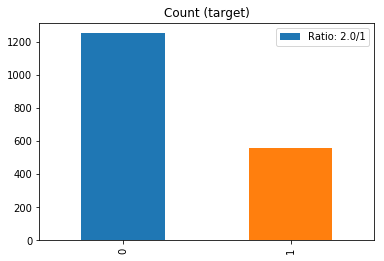

In [7]:
#: Is the dataframe balanced? 
#: Yes, a ratio of 2 is accetable (above 10 resampling with improve the accuracy of the model)

target_count = df[target].value_counts()
print('class 0 count: {}'.format(target_count[0]))
print('class 1 count: {}'.format(target_count[1]))
print('Ratio: {}/1'.format(int(target_count[0] / target_count[1])))
target_count.plot(kind='bar', title='Count (target)', label='Ratio: {}/1'.format(round(target_count[0] / target_count[1], 2)))
plt.legend(loc='best')
plt.show()

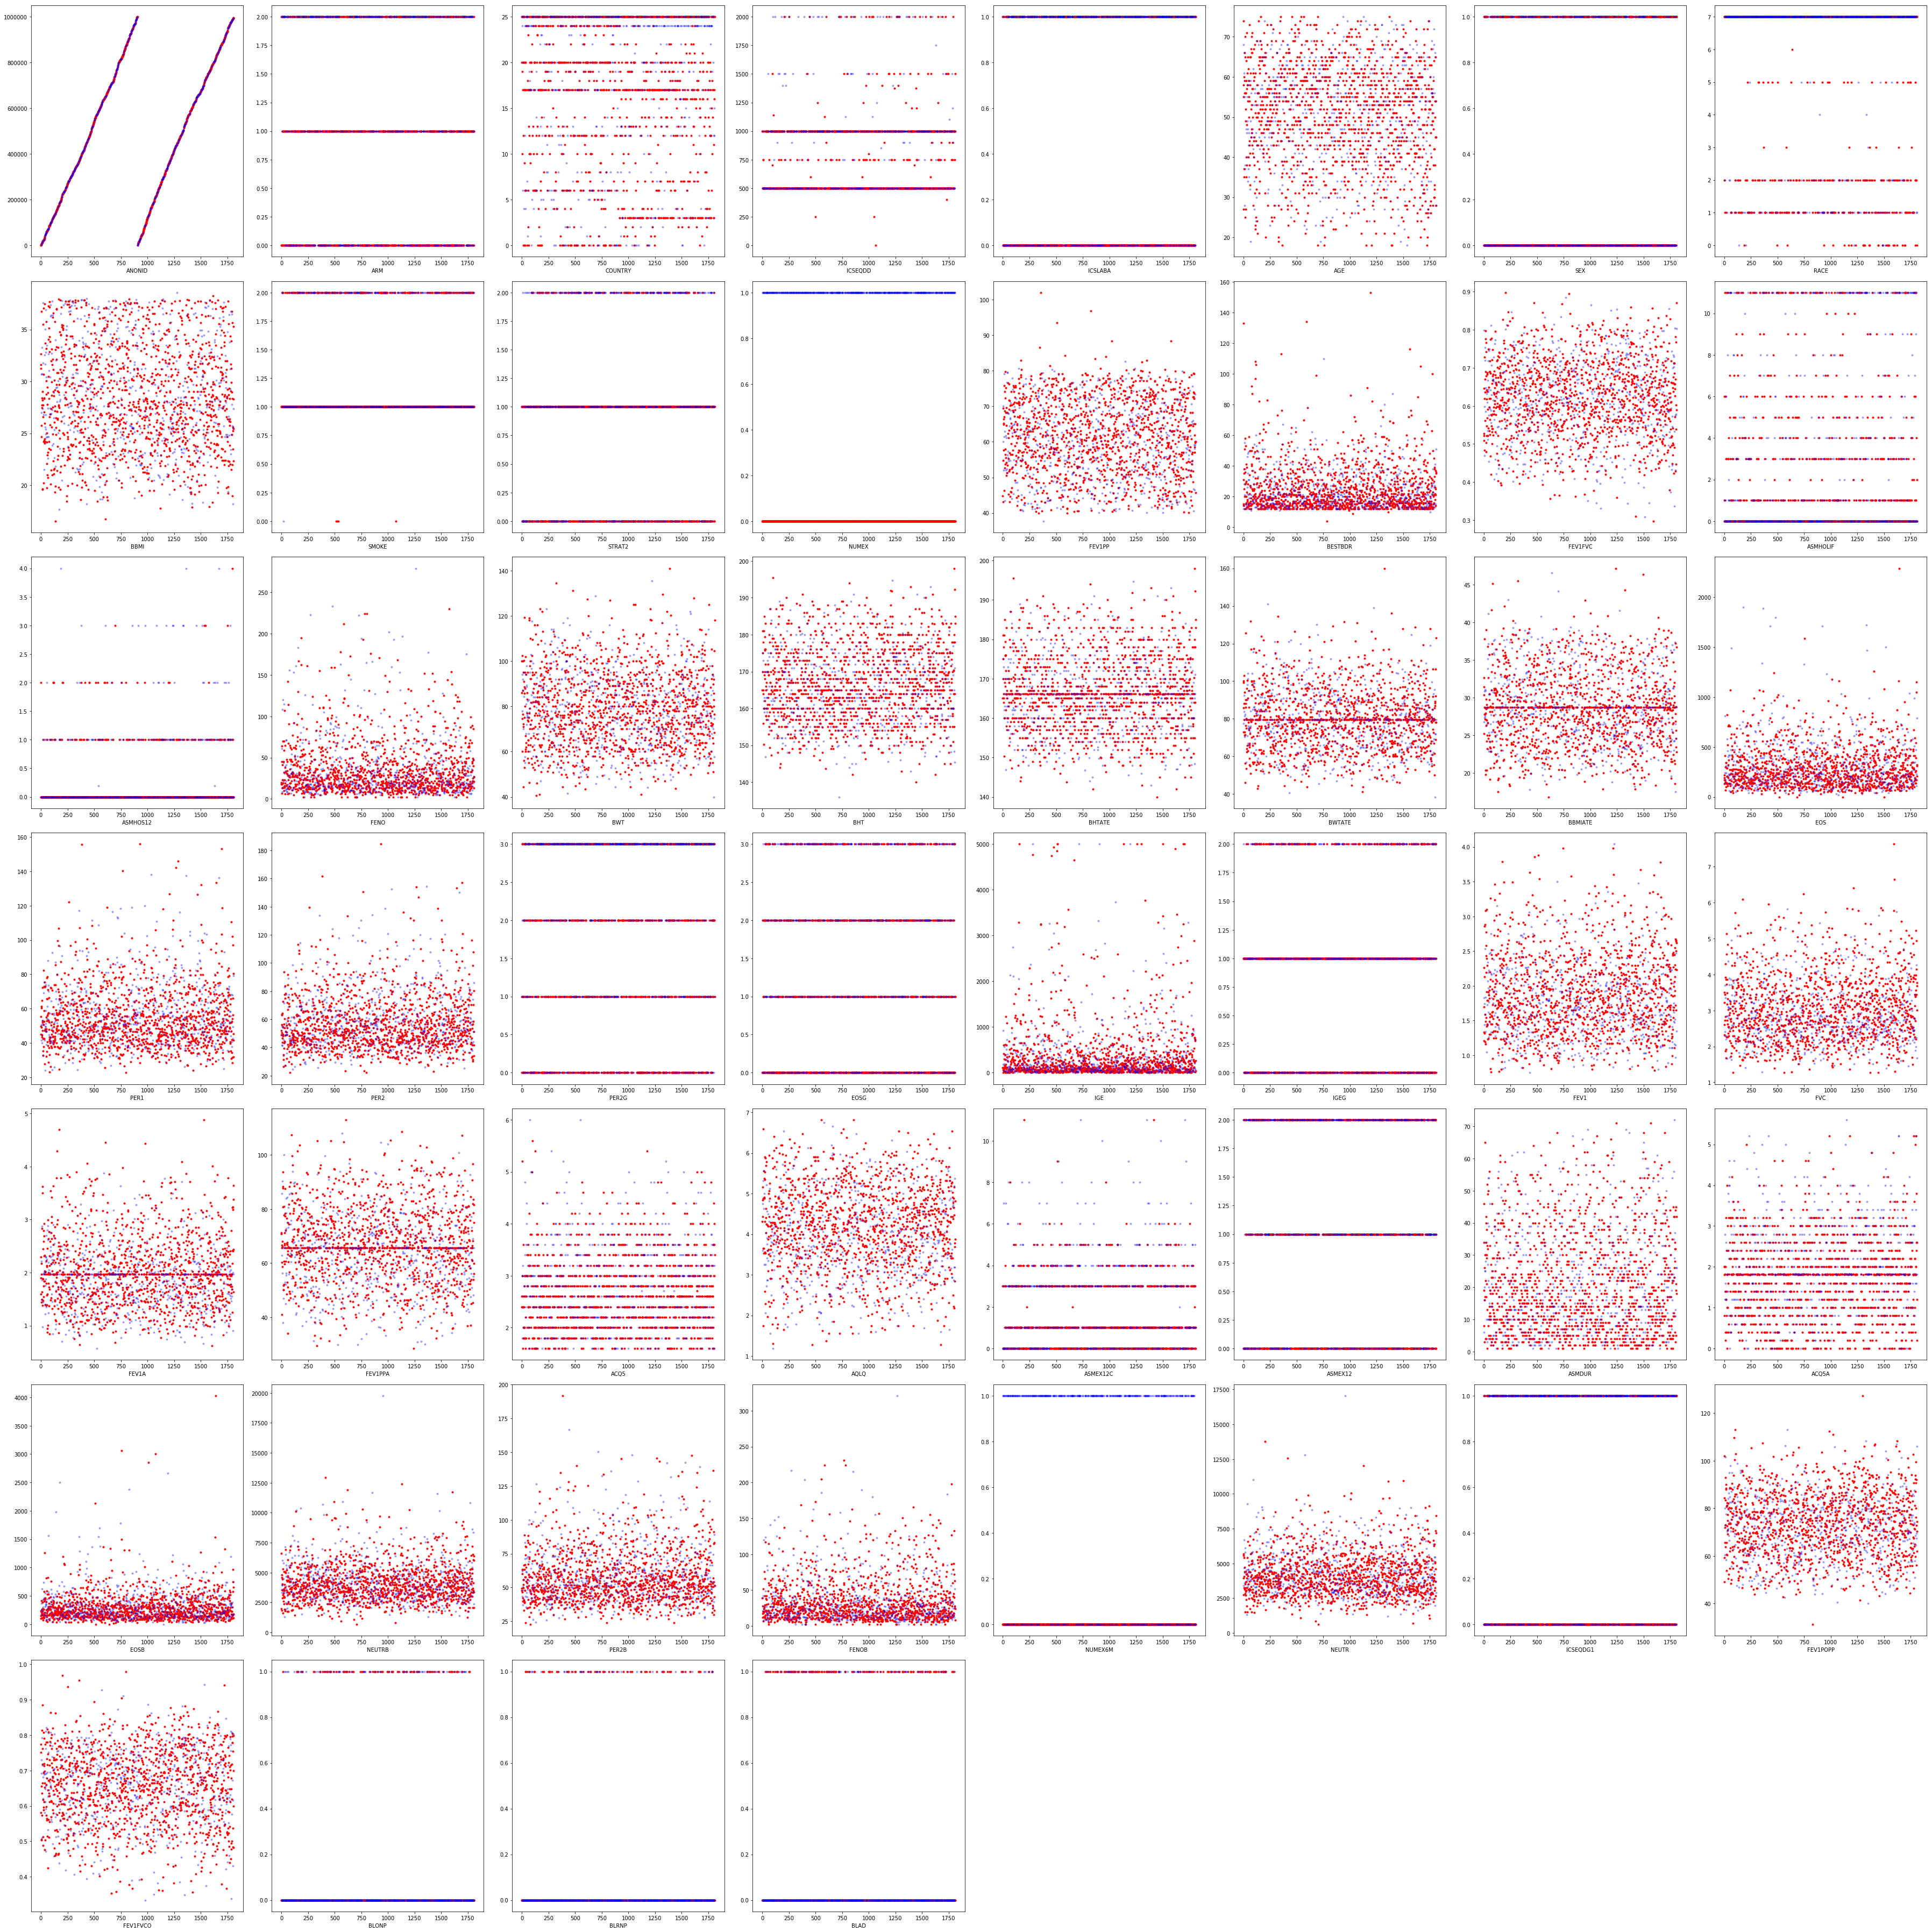

In [8]:
#: Let's all the different features for patients who had no relapse in red and patients that had a relapse in blue.
#: This way we examine if there is an evident correlation or/and if the distributions of relapsing/
#: not relapsing patients are significally different

features_to_examine = df_label.columns.tolist()

nfeat=len(features_to_examine)
fig = plt.figure(figsize=(50,50))

counter=1
for j in xrange(nfeat):
        plt.subplot(math.sqrt(nfeat), math.ceil(math.sqrt(nfeat)), counter)
        counter += 1
        plt.plot(df_label[features_to_examine[j]][df_label[target]==0],'r.', )
        plt.plot(df_label[features_to_examine[j]][df_label[target]==1], 'b.', alpha=0.3)
        plt.xlabel(features_to_examine[j])
        fig.tight_layout()

plt.savefig('features_vs_{}.png'.format(target))        
plt.show()

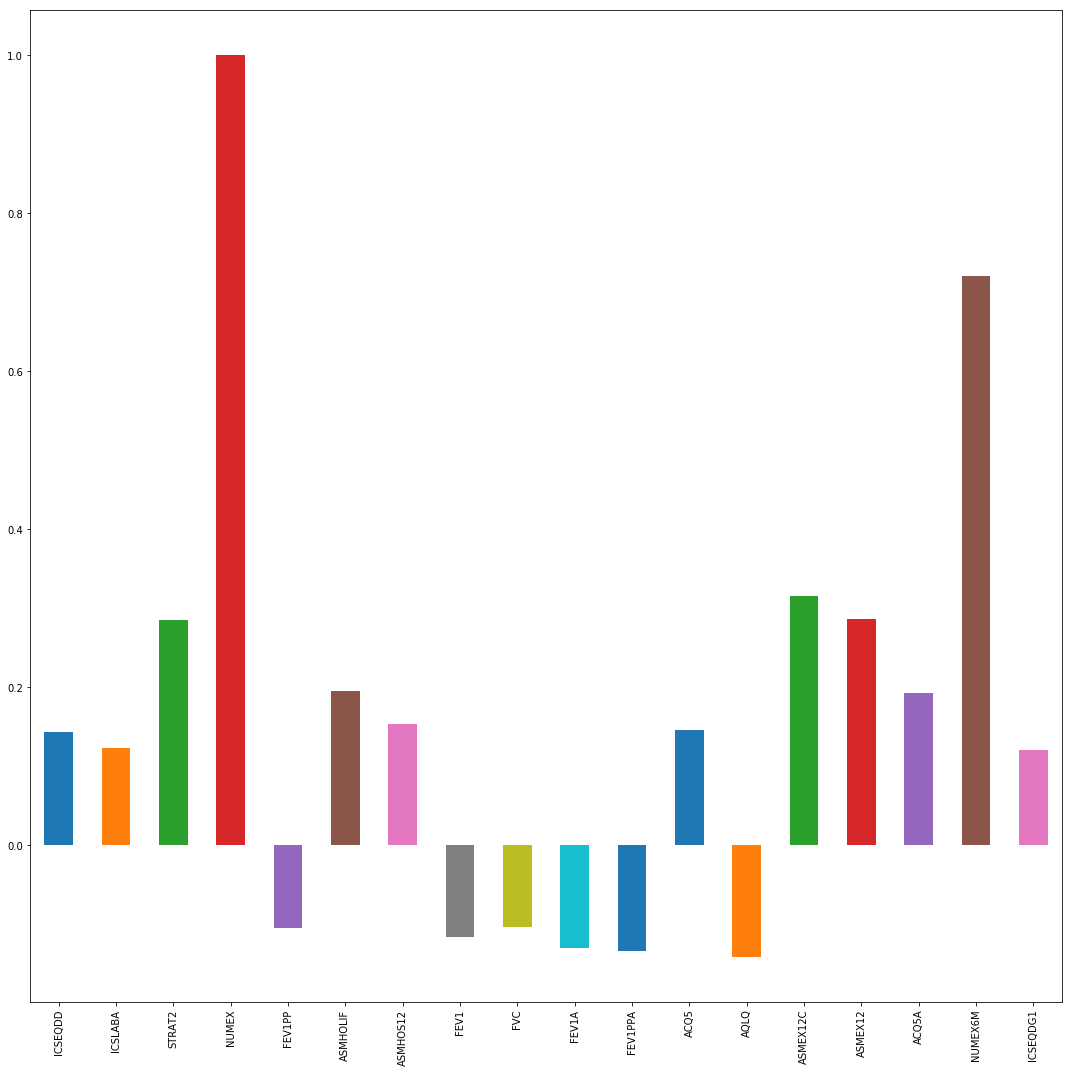

In [9]:
#: Let's print the correlation of the target with the others variables

df_label.corr()[target][df_label.corr()[target].abs() > 0.1].plot(kind='bar', figsize=(15,15))
plt.tight_layout()
plt.savefig('{}_correlation_label_enconding'.format(target)) #figure will be saved as saved_figure.png

### The model

#### Preparing the numerical dataframes

In [10]:
#: the target values
target_values = df[target].values

#: list of columns for the feature df
list_columns={}
list_columns['hot'] = df_hot.filter(regex='AGE|RACE|BBMI|SMOKE|ASMEX12|FVC|ACQ5A|ASMHOLIF|COUNTRY|ARM').columns.tolist()
list_columns['label'] = ['AGE', 'RACE', 'BBMI', 'SMOKE', 'ASMEX12', 'ASMEX12C', 'FVC', 'ACQ5A', 'ASMHOLIF', 'COUNTRY', 'ARM'] 

#: features df
features = {}
features['hot'] = df_hot[list_columns['hot']]
features['label'] = df_label[list_columns['label']]

features['hot'] = features['hot'].values
features['label'] = features['label'].values

#### The Classifier and the search grid

In [11]:
decision_xgb = XGBClassifier()

optimization_dict = {'max_depth': [2,3,4,5,6], #usually: 3 --10
                     'n_estimators': [50,100,200], 
                    'learning_rate': [0.1, 0.2, 0.5]}

In [ ]:
#: let's train the model(s) with the 2 datasets

model={}
for item in ['hot', 'label']:
    model[item] = GridSearchCV(decision_xgb, 
                               optimization_dict, 
                               cv=10, 
                               scoring = 'roc_auc', 
                               verbose=1, 
                               return_train_score=True)
    
    model[item].fit(features[item], target_values)

    print('{} encoding best score: {}'.format(item, model[item].best_score_))
    print('{} encoding best param {}'.format(item, model[item].best_params_))
    

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


#### Shap evaluation

In [ ]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
for item in ['hot', 'label']:
    
    explainer = shap.TreeExplainer(model[item].best_estimator_)
    shap_values = explainer.shap_values(features[item])

    shap.summary_plot(shap_values, features[item], plot_type="bar", feature_names=list_columns[item], show=False)
    #plt.tight_layout()
    plt.savefig('shap_summary_{}.png'.format(item))
    plt.show()
    
    shap.summary_plot(shap_values, features[item], feature_names=list_columns[item], show=False)
    #plt.tight_layout()
    plt.savefig('shap_summary_barplot_{}.png'.format(item))
    plt.show()
    

#### Comparing the 2 roc curves

In [ ]:
#: Calculating the scores of the two different models

probs,auc = {}, {}
for item in ['hot', 'label']:
    probs[item] = model[item].predict_proba(features[item])
    probs[item] = probs[item][:, 1]
    auc[item] = metrics.roc_auc_score(target_values, probs[item])


In [ ]:
#: Plot the ROC curve 

fig, ax = plt.subplots(figsize=(15,15))     
for item in ['hot', 'label']:
    # calculate roc curve
    fpr, tpr, thresholds = metrics.roc_curve(target_values, probs[item])

    # plot worst case line
    ax.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    ax.plot(fpr, tpr, marker='.', label='MODEL {} - AUC score {}'.format(item.upper(),auc[item]))

ax.legend(loc='lower right')
ax.grid(1)
fig.savefig('Roc_curve_asthma_models.png')

Notes:  
-) As expected the Hot encoding is performing bettere then the label encoding, but only slighty  
-) Having a look at the shap summary, we may infer that the COUNTRY column is not balanced and make the model slightly overfit  
-) Since the label encoding is 3 times faster the the hot enconding, it may make sense to use the label encoding since the accuracy gain using the hot encoding is minimal.